### Importación de las librerías a utilizar

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [342]:
df_bank = pd.read_csv('bank_dataset.CSV', header=0, delimiter= ",")

Elimino las variables/columnas que no necesitaré para el proyecto.

In [343]:
df_bank = df_bank.drop(columns=['contact', 'default', 'day', 'month', 'duration','campaign', 'pdays','poutcome', 'previous'])

In [344]:
df_bank.head()

,age,job,marital,education,balance,housing,loan,deposit
0,59.0,admin.,married,secondary,2343,yes,no,yes
1,56.0,admin.,married,secondary,45,no,no,yes
2,41.0,technician,married,secondary,1270,yes,no,yes
3,55.0,services,married,secondary,2476,yes,no,yes
4,54.0,admin.,married,tertiary,184,no,no,yes


Localizo los valores nulos

In [345]:
df_bank.isnull().sum()

age          10
job           0
marital       5
education     7
balance       0
housing       0
loan          0
deposit       0
dtype: int64

En el caso de age utilizaré la media de marital para completar los valores faltantes

In [346]:
avg_ages = df_bank.groupby("marital")["age"].mean().round()

for status, avg_age in avg_ages.items():
    df_bank.loc[(df_bank["marital"] == status) & (df_bank["age"].isna()), "age"] = avg_age

En la variable `age` observo también que los valores dentro de esta presentan números decimales y es del tipo (float); no tiene sentido que se mantenga así y cambio el tipo a (int)

In [347]:
df_bank['age'] = df_bank['age'].astype('int')

En el caso de la variable `marital` utilizo la moda para imputar los valores nulos

In [348]:
moda_marital = df_bank.groupby(['job', 'age'])['marital'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df_bank['marital'] = df_bank['marital'].fillna(moda_marital)

Para la variable `education` utilizo la moda para imputar los valores nulos

In [349]:
moda_education = df_bank.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df_bank['education'] = df_bank['education'].fillna(moda_education)

In [350]:
# Compruebo que se hayan eliminado los valores nulos

df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

Observo que en la variable de `job` hay varias categorías, enlisto la cantidad de clientes que hay por cada una, por lo que probaré crear subgrupos para reducir la cantidad de categorías de esta variable, buscando evitar tener muchas columnas cuando trabaje con la codificación de esta variable y su posterior uso al trabajar con el algoritmo (K-MEans Clustering).

In [351]:
cantidades_education = df_bank.groupby('job').size()
print(cantidades_education)

job
admin.           1334
blue-collar      1944
entrepreneur      328
housemaid         274
management       2566
retired           778
self-employed     405
services          923
student           360
technician       1823
unemployed        357
unknown            70
dtype: int64


Decido crear 5 categorías para probar reducir la dimensión de esta variable previo a la codificación

In [352]:
job_mapeo = {
    "admin.": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro"
}

df_bank['job'] = df_bank['job'].replace(job_mapeo)

print(df_bank['job'].value_counts())

job
profesional    6456
manual         3141
otro            787
retired         778
Name: count, dtype: int64


En la tarea previa de EDA vi que existían una cantidad importante de outliers, a los cuales contemplo pasar por la técnica de winsorizarlos en lugar de eliminarlos, aún así creo una copia para no perder los datos de origen

In [353]:
df_bank_w = df_bank.copy()

df_bank_w['age'] = winsorize(df_bank['age'], limits= [0.05, 0.05], inplace= True)

df_bank_w['balance'] = winsorize(df_bank['balance'], limits= [0.05, 0.05], inplace= True)

Para personalizar el dataframe decido traducir al español los elementos dentro de este y así hacerlo más comprensible a las personas que lo puedan necesitar

In [354]:
df_bank_w["marital"] = np.where(df_bank_w["marital"] == "married", "casado",
                                np.where(df_bank_w["marital"] == "single", "soltero",
                                         "divorciado"))

df_bank_w["education"] = np.where(df_bank_w["education"] == "primary", "primaria",
                                np.where(df_bank_w["education"] == "secondary", "media",
                                         "superior"))

df_bank_w["housing"] = np.where(df_bank_w["housing"] == "no", "no", "sí")

df_bank_w["deposit"] = np.where(df_bank_w["deposit"] == "no", "no", "sí")

df_bank_w["job"] = np.where(df_bank_w["job"] == "retired", "retirado", df_bank_w['job'])

# Renombro las columnas

df_bank_w = df_bank_w.rename(columns={
    'age': 'edad',
    'job': 'trabajo',
    'marital': 'estado_civil',
    'education': 'educacion',
    'balance': 'saldo',
    'housing': 'hipoteca',
    'loan': 'prestamos',
    'deposit': 'deposito'
})

df_bank_w.head()

,edad,trabajo,estado_civil,educacion,saldo,hipoteca,prestamos,deposito
0,59,profesional,casado,media,2343,sí,no,sí
1,56,profesional,casado,media,45,no,no,sí
2,41,profesional,casado,media,1270,sí,no,sí
3,55,manual,casado,media,2476,sí,no,sí
4,54,profesional,casado,superior,184,no,no,sí


Utilizaré One-Hot Encoding para codificar las variables categóricas y así puedan ser tratadas con mayor facilidad en el modelo de ML que he elegido.

In [355]:
df_bank_w = pd.get_dummies(df_bank_w, columns=['trabajo', 'estado_civil', 'educacion', 'hipoteca', 'prestamos', 'deposito'])
df_bank_w = df_bank_w.astype(int)

df_bank_w.head()

,edad,saldo,trabajo_manual,trabajo_otro,trabajo_profesional,trabajo_retirado,estado_civil_casado,estado_civil_divorciado,estado_civil_soltero,educacion_media,educacion_primaria,educacion_superior,hipoteca_no,hipoteca_sí,prestamos_no,prestamos_yes,deposito_no,deposito_sí
0,59,2343,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1
1,56,45,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1
2,41,1270,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1
3,55,2476,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1
4,54,184,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,1


Separación de Datos de Entrenamiento/Prueba

In [356]:
from sklearn.model_selection import train_test_split

# División en entrenamiento y prueba
X_train, X_test = train_test_split(df_bank_w, test_size=0.30, random_state=0)


print("Conjunto de entrenamiento:\n", X_train.shape)
print("Conjunto de prueba:\n", X_test.shape)

Conjunto de entrenamiento:
 (7813, 18)
Conjunto de prueba:
 (3349, 18)


Estandarización de las Variables Numéricas

In [357]:
# Selecciono solo las columnas a estandarizar
scale_variable = ['edad', 'saldo']

# Creo el escalador 
scaler = StandardScaler()

# Ajusto el escalador y aplico la estandarización a los datos de entrenamiento
X_train[scale_variable] = scaler.fit_transform(X_train[scale_variable])

# Aplico la estandarizacion a los datos de prueba
X_test[scale_variable] = scaler.transform(X_test[scale_variable])

X_train.head()

,edad,saldo,trabajo_manual,trabajo_otro,trabajo_profesional,trabajo_retirado,estado_civil_casado,estado_civil_divorciado,estado_civil_soltero,educacion_media,educacion_primaria,educacion_superior,hipoteca_no,hipoteca_sí,prestamos_no,prestamos_yes,deposito_no,deposito_sí
2265,1.342796,0.244250,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1
1525,-0.176727,-0.791871,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1
1837,0.962915,1.066750,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1
9423,-0.271698,-0.791871,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
8111,-0.461638,-0.634974,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0


In [358]:
X_test.head()

,edad,saldo,trabajo_manual,trabajo_otro,trabajo_profesional,trabajo_retirado,estado_civil_casado,estado_civil_divorciado,estado_civil_soltero,educacion_media,educacion_primaria,educacion_superior,hipoteca_no,hipoteca_sí,prestamos_no,prestamos_yes,deposito_no,deposito_sí
9058,0.013213,-0.705578,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0
3279,1.437766,0.410801,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1
6502,-1.031459,-0.610837,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0
9327,-0.651578,0.083732,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0
9965,-1.126429,-0.766526,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0


Aplico el PCA

In [359]:
from sklearn.decomposition import PCA

# obtengo los componentes principales
pca = PCA()

# ajusto el pca y aplico la reducción de dimensionalidad a los datos de entrenamiento
X_train_reducido = pca.fit_transform(X_train)

# aplico la reducción de dimensionalidad a los datos de prueba
X_test_reducido = pca.transform(X_test)

Realizo una visualización de los datos de entrenamiento

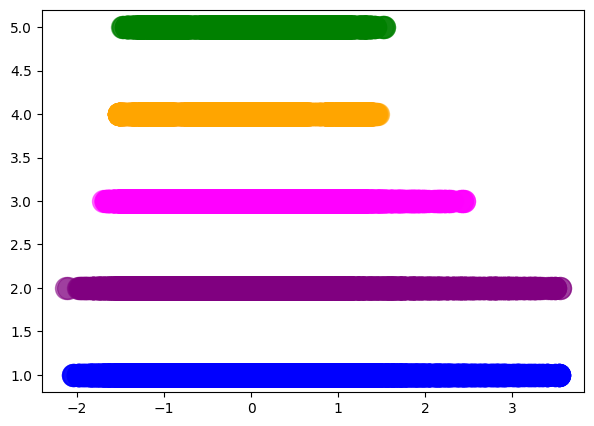

In [363]:
import matplotlib.pyplot as plt

# visualización - datos de entrenamiento
plt.figure(figsize=(7, 7))
plt.axes().set_aspect("equal")
plt.scatter(X_train_reducido[:, 0], [1] * X_train_reducido[:, 0].size, s=250, color="blue", alpha=0.5)
plt.scatter(X_train_reducido[:, 1], [2] * X_train_reducido[:, 1].size, s=250, color="purple", alpha=0.5)
plt.scatter(X_train_reducido[:, 2], [3] * X_train_reducido[:, 2].size, s=250, color="magenta", alpha=0.5)
plt.scatter(X_train_reducido[:, 3], [4] * X_train_reducido[:, 3].size, s=250, color="orange", alpha=0.5)
plt.scatter(X_train_reducido[:, 4], [5] * X_train_reducido[:, 4].size, s=250, color="green", alpha=0.5)

plt.ylim((0.8, 5.2))
plt.show()

In [361]:
# Configuro el formato para evitar la notación científica
np.set_printoptions(suppress=True, precision=8)

# Varianza explicada
print("Varianza explicada por cada componente:", pca.explained_variance_)
print("Proporción de varianza explicada por cada componente:", pca.explained_variance_ratio_)

Varianza explicada por cada componente: [1.23726813 0.97137677 0.63881775 0.48004508 0.38052778 0.32185306
 0.30553275 0.21723056 0.13379519 0.12277422 0.0979796  0.05442445
 0.         0.         0.         0.         0.         0.        ]
Proporción de varianza explicada por cada componente: [0.2493675  0.19577794 0.12875171 0.09675158 0.07669418 0.06486847
 0.06157917 0.04378214 0.026966   0.02474476 0.01974748 0.01096908
 0.         0.         0.         0.         0.         0.        ]
